# Proyecto Uno - Analítica de Textos

Integrantes:

- Tomas Alberto Rodríguez Peña.
- Andres Caballero.
- Adriana Sofía Rozo Cepeda.

# Entendimiento del negocio y enfoque analítico

La proliferación de noticias falsas en plataformas digitales y redes sociales representa una amenaza para la estabilidad política y la confianza en la información. En nuestro país Colombia, este fenómeno ha sido utilizado para influir en elecciones, generar desinformación en torno a políticas públicas y profundizar la polarización social.

Por lo anterior, detectar y mitigar la propagación de noticias falsas mediante herramientas automatizadas de aprendizaje automático representa una gran oportunidad para fortalecer la calidad del debate público y la toma de decisiones informadas.

[En este documento](https://github.com/Inteligencia-de-Negocios-202501/proyecto-analitica-de-datos/blob/main/docs/Entendimiento%20del%20negocio%20y%20enfoque%20anal%C3%ADtico.pdf) abordamos el **Entendimiento del negocio y enfoque analítico**. Mostramos las generalidades, que incluyen los objetivos, criterios de éxito y rol de los beneficiados. Por otra parte, también encontramos el Impacto y Enfoque analítico. Los invitamos a explorar este documento antes de abordar el notebook.


#  1. Ownml Machine Learning Canvas

Además de lo tratado en el documento, el ML Canvas basado en CRISP-ML(Q) es una herramienta fundamental en el desarrollo de modelos de aprendizaje automático, ya que proporciona una estructura clara y organizada para el proceso de análisis y modelado. Este marco metodológico permite desglosar cada fase del ciclo de vida del modelo, desde la recolección y preparación de datos hasta la evaluación y monitoreo del desempeño. Con esta herramienta, garantizaremos que las decisiones tomadas en cada etapa sean justificadas y alineadas con los objetivos del negocio.

Para acceder al desarrollo completo del ML Canvas aplicado en este proyecto, puede visitar el siguiente enlace: [ML Canvas](https://github.com/Inteligencia-de-Negocios-202501/proyecto-analitica-de-datos/blob/main/docs/Machine%20Learning%20Canvas.pdf)

-

# 2. Entendimiento y preparación de los datos

### 2.1 Instalación e importación de librerías

In [ ]:
%%capture
!pip install pandas matplotlib seaborn numpy
!pip install contractions
!pip install spacy

# Librerías para procesamiento de lenguaje natural (NLP) en español
!python -m spacy download es_core_news_sm

# Perfilamiento de datos
!pip install ydata-profiling
# Modelos y procesamiento de texto
!pip install scikit-learn xgboost lightgbm

!pip install chardet nltk

In [ ]:
%%capture
# Librerías necesarias para el análisis de datos y visualización

# Manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from ydata_profiling import ProfileReport
from datetime import datetime
import re, string, unicodedata


# Descarga de recursos de NLTK
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download('wordnet')

# Procesamiento de lenguaje natural (NLP)
import spacy
from scipy import stats as st
import contractions
import inflect
from contractions import fix
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud


# Modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Carga del modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")


In [ ]:
# Carga de datos
file_path = "./data/fake_news_spanish.csv"

with open(file_path, "rb") as f:
    result = chardet.detect(f.read(100000))
encoding_detected = result["encoding"]
encoding_detected


'utf-8'

In [ ]:
df = pd.read_csv(file_path, encoding=encoding_detected, sep=None, engine="python", header=0)
df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


## 2.2 Entendimiento de los datos

Para comenzar nuestro proyecto es fundamental familiarizarnos con la estructura de los datos proporcionados. Para esto realizaremos "estadísticas descriptivas".

1. Como podemos ver, tenemos 57063 observaciones (noticias) correspondientes a 5 atributos que son ID, Label, Titulo, Descripción y Fecha.

In [ ]:
df.shape

(57063, 5)

In [ ]:
df.columns

Index(['ID', 'Label', 'Titulo', 'Descripcion', 'Fecha'], dtype='object')

In [ ]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


2. En cuanto al atributo Label, encontramos un desbalance entre clases ya que hay más noticias reales (1) que falsas (0). Esto podría influir en el entrenamiento del modelo, ya que un modelo sesgado podría favorecer la clase mayoritaria. Esto lo tomaremos en cuenta más adelante.

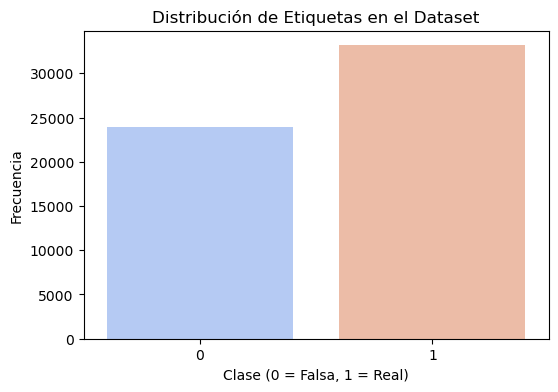

In [ ]:
label_counts = df["Label"].value_counts()
label_counts
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="coolwarm", legend=False)
plt.xlabel("Clase (0 = Falsa, 1 = Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Etiquetas en el Dataset")
plt.show()


In [ ]:
falsas = label_counts[0]
reales = label_counts[1]

print(f"Noticias falsas: {falsas}")
print(f"Noticias reales: {reales}")

Noticias falsas: 23905
Noticias reales: 33158


3. A continuación realizamos un análisis estadístico de las descripciones en el dataset. Este análisis muestra una alta variabilidad en la longitud de los textos.

In [ ]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Descripcion']]
textos['Moda'] = [st.mode([len(x) for x in i.split(' ')], keepdims=True)[0][0] for i in textos['Descripcion']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]

textos

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,218,2,13,1
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,3251,2,17,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,169,2,13,2
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,133,3,15,2
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,242,2,14,1
...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,244,2,12,1
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,314,3,11,1
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,70,2,11,2
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,232,2,12,1



  Vemos que las descripciones en promedido tienen 243 caracteres, pero la desviación estándar de 273 sugiere una distribución dispersa, con algunas descripciones significativamente más largas o más cortas.

  El valor máximo que vemos de 14,019 caracteres indica la presencia de valores atípicos que requieren revisión. Ahora bien, en cuanto a la moda de la longitud de las palabras dentro de cada descripción es de aproximadamente 2 caracteres, lo que sugiere la predominancia de palabras cortas. Asimismo, la longitud mínima de las palabras dentro de las descripciones varía entre 0 y 3 caracteres, lo que podría indicar la presencia de ruido o errores en la tokenización.

  En etapas posteriores analizaremos los valores extremos y limpiaremos posibles datos anomalías antes de aplicar técnicas de procesamiento de lenguaje natural.

In [ ]:
textos.describe()

,Label,Conteo,Moda,Max,Min
count,57063.000000,57063.000000,57063.000000,57063.000000,57063.000000
mean,0.581077,243.448697,2.219687,12.711915,1.165554
std,0.493387,273.253727,0.834107,2.123055,0.384203
min,0.000000,33.000000,1.000000,6.000000,0.000000
25%,0.000000,171.000000,2.000000,11.000000,1.000000
50%,1.000000,221.000000,2.000000,13.000000,1.000000
75%,1.000000,267.000000,2.000000,14.000000,1.000000
max,1.000000,14019.000000,12.000000,69.000000,3.000000


Podemos corroborar lo anterior, en los siguientes diagramas de bigotes:

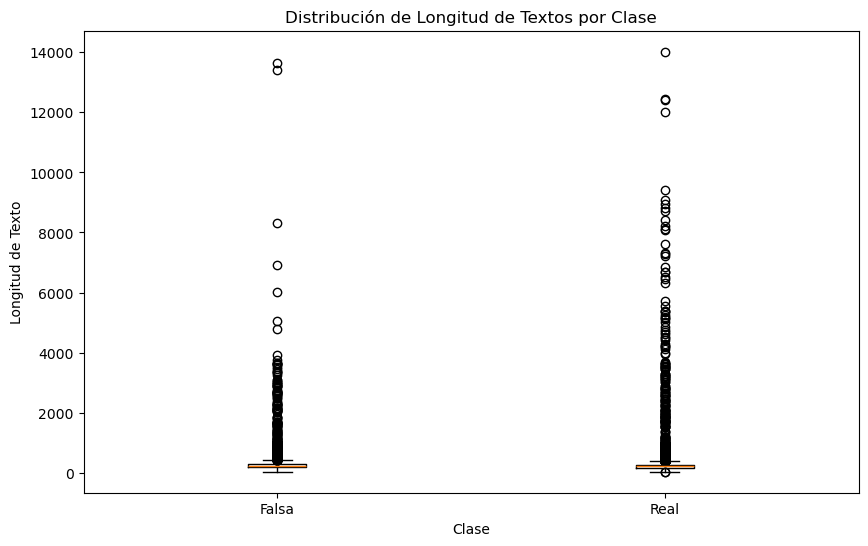

In [ ]:
# Diagramas de Bigotes
plt.figure(figsize=(10, 6))
plt.boxplot([textos[textos['Label'] == 0]['Conteo'], textos[textos['Label'] == 1]['Conteo']])
plt.xticks([1, 2], ['Falsa', 'Real'])
plt.title('Distribución de Longitud de Textos por Clase')
plt.xlabel('Clase')
plt.ylabel('Longitud de Texto')
plt.show()

El boxplot anterior muestra que la mayoría de los textos tienen una longitud inferior a 300 caracteres, pero existen valores atípicos que superan los 14,000 caracteres. Estos outliers evidencian una gran dispersión en la longitud de los textos dentro de ambas clases, lo que indica que, aunque la mediana y los cuartiles sugieren textos relativamente cortos, una parte significativa del conjunto de datos contiene textos considerablemente más largos.

Ademas, la presencia de estos outliers puede influir en el comportamiento del modelo de clasificación, ya que pueden sesgar la distribución de los datos y generar diferencias en la forma en que el modelo aprende a distinguir entre textos falsos y reales. Además, su impacto en el entrenamiento podría alterar los pesos asignados a la longitud del texto como característica predictiva, afectando la estabilidad y generalización del modelo.

### 2.2.1 Perfilamiento de los datos

In [ ]:
perfil = ProfileReport(df, title="Perfilamiento de Datos", explorative=True)
perfil.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


Gracias a este reporte tenemos los siguientes insights:

**Estadísticas Generales**

- Número de variables: 5  
- Número de observaciones: 57,063  
- Celdas con valores faltantes: 16 (< 0.1%)  
- Filas duplicadas: 430 (0.8%)  
- Tamaño total en memoria: 52.9 MiB  
- Tamaño promedio de cada registro en memoria: 971.8 B  

**Clasificación de Variables**


| Variable       | Tipo de Dato | Descripción |
|---------------|-------------|-------------|
| Label     | Numérica (0 o 1) | Etiqueta binaria que indica si la noticia es real (1) o falsa (0). |
| Titulo    | Texto        | Contiene el titular de la noticia. |
| Descripcion | Texto      | Breve resumen o contenido de la noticia. |
| Fecha     | DateTime     | Fecha en la que se publicó la noticia. |
| ID        | Categórica (Constante) | Se detectó que la columna ID tiene un único valor constante y no aporta información relevante. |

**Observaciones**

1. **Diversidad del contenido textual**  
   - La variable `Titulo` tiene un 90.5% de valores distintos, mientras que `Descripcion` presenta un 87% de valores únicos, lo que indica una amplia variedad en el contenido.

2. **Distribución de etiquetas (Balance de Clases)**  
   - Como mencionamos anteriormente, variable `Label` muestra una distribución ligeramente desbalanceada, con más noticias reales (1) que falsas (0). Esto puede afectar el rendimiento del modelo y podría ser necesario aplicar técnicas de balanceo como sobremuestreo o submuestreo.

3. **Presencia de valores nulos y duplicados**  
   - Hay 16 valores nulos en `Titulo`.
   - Se detectaron 430 filas duplicadas, lo que podría indicar problemas en la recolección de datos o noticias repetidas.

4. **Longitud de los textos**  
   - Se identificaron palabras extremadamente cortas (1-2 caracteres) y descripciones de hasta 14,019 caracteres, lo que sugiere la presencia de valores atípicos.

## 2.3 Análisis de Calidad de los Datos

### 2.3.1 Completitud

El análisis de completitud de los datos muestra que la mayoría de las columnas no tienen valores faltantes, excepto la columna "Titulo", que tiene 16 valores nulos (57,047 valores completos de 57,063 registros totales).

Esto sugiere que, en general, el conjunto de datos está bien estructurado, pero **manejaremos los valorres faltantes en "Titulo"** para evitar problemas en el análisis posterior. Entonces, la completitud total del conjunto de datos en este momento es del 99,97%.

In [ ]:
datos_completos = df.notnull().sum()
print(datos_completos)

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64


In [ ]:
# Completitud por columna
completitud_columna = (1 - df.isnull().sum() / len(df)) * 100
print("Completitud por columna:\n", completitud_columna)

# Completitud por fila
completitud_fila = (1 - df.isnull().sum(axis=1) / df.shape[1]) * 100
print("Completitud por fila:\n", completitud_fila)

# Completitud de la tabla
completitud_tabla = (1 - df.isnull().any(axis=1).sum() / len(df)) * 100
print("Completitud de la tabla: ", completitud_tabla)

Completitud por columna:
 ID             100.000000
Label          100.000000
Titulo          99.971961
Descripcion    100.000000
Fecha          100.000000
dtype: float64
Completitud por fila:
 0        100.0
1        100.0
2        100.0
3        100.0
4        100.0
         ...  
57058    100.0
57059    100.0
57060    100.0
57061    100.0
57062    100.0
Length: 57063, dtype: float64
Completitud de la tabla:  99.9719608152393


### 2.3.2 Unicidad

Contamos primero los duplicados considerando todas las columnas.


In [ ]:
df.duplicated().sum()

445

In [ ]:
df.duplicated().sum()/len(df)*100

0.7798398261570545

Como se evidencia anteriormente, la diferencia entre el número de filas duplicadas reportadas por **Pandas Profiling** (430) y el resultado obtenido con `df.duplicated().sum()` (445) puede deberse a cómo cada método maneja los valores faltantes. **Pandas Profiling** podría estar descartando previamente las filas con valores nulos antes de calcular los duplicados, mientras que `df.duplicated().sum()` considera una fila como duplicada incluso si contiene valores nulos en alguna columna. Esto sera tratado cuando se realicen las transformaciones tanto para los valores nulos como los duplicados.

Ahora bien, la gráfica a continuación muestra que varias noticias han sido reportadas múltiples veces, siendo el caso más frecuente el escándalo de corrupción que salpica a líderes sindicales, con un total de 6 apariciones en el dataset. Otras noticias, como la polémica reforma laboral que genera protestas y la investigación a un político por fraude fiscal, también presentan altos niveles de duplicación, lo que sugiere que ciertos temas tienen una mayor presencia en el conjunto de datos.

Consideramos que la redundancia de datos puede generar sesgos y afectar el equilibrio de las clases. **Por lo tanto, consideraremos la eliminación de duplicados**, para mejorar la calidad del dataset y optimizar el rendimiento del modelo de machine learning.

<Figure size 1000x500 with 0 Axes>

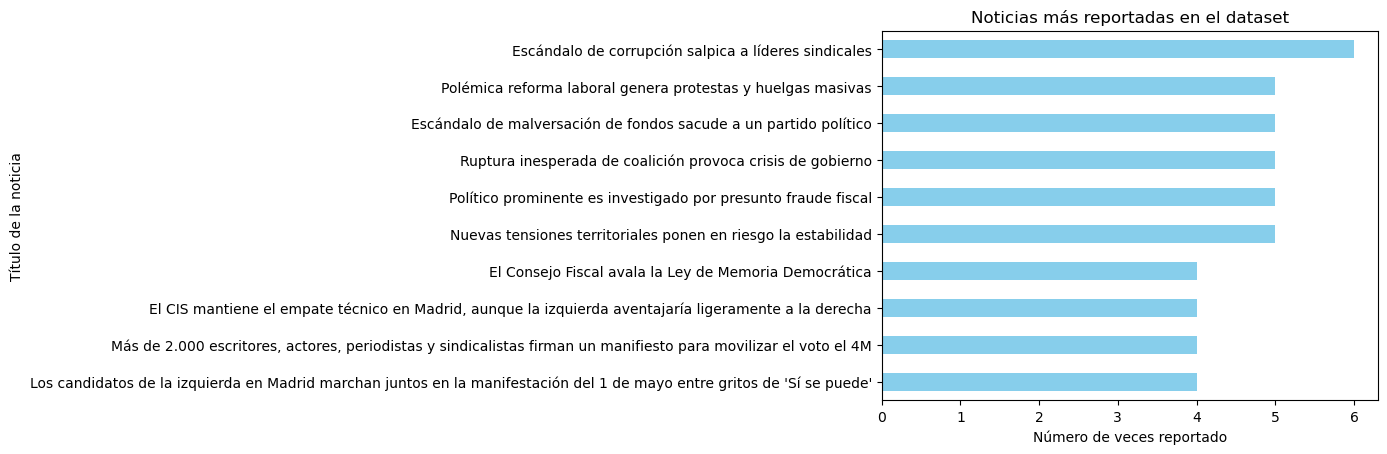

In [ ]:
columnas_relevantes = ["ID", "Label", "Titulo", "Descripcion", "Fecha"]

df = df[columnas_relevantes] if set(columnas_relevantes).issubset(df.columns) else df

df["# duplicates"] = df.groupby("Titulo")["Titulo"].transform("count")

df_unique = df.drop_duplicates(subset=["Titulo"]).sort_values(by="# duplicates", ascending=False)


plt.figure(figsize=(10, 5))
df_unique.head(10).plot(kind="barh", x="Titulo", y="# duplicates", legend=False, color="skyblue")
plt.xlabel("Número de veces reportado")
plt.ylabel("Título de la noticia")
plt.title("Noticias más reportadas en el dataset")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
df.drop(columns="# duplicates", axis=1, inplace=True)

### 2.3.3 Consistencia

En esta parte analizaremos que la información dentro del dataset sea confiable y utilizable para el modelo de machine learning. Nos enfocaremos en identificar errores de formato, diferencias en la representación de datos y posibles inconsistencias semánticas.

1. Consistencia Estructural

Vemos que la columna Label es consistente con los únicos valores que debe tomar 0=Fake New, 1=No Fake New.

In [ ]:
def check_structural_consistency(df):
    print("\n--- Consistencia estructural ---")
    print("Tipos de datos:\n", df.dtypes)
    print("Valores únicos en Label:\n", df["Label"].unique())

check_structural_consistency(df)


--- Consistencia estructural ---
Tipos de datos:
 ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object
Valores únicos en Label:
 [1 0]


2. Consistencia semántica

In [ ]:
def check_semantic_consistency(df):
    expected_columns = ["ID", "Label", "Titulo", "Descripcion", "Fecha"]
    print("\n--- Consistencia semántica ---")
    print("Columnas esperadas vs reales:", set(expected_columns) == set(df.columns))
    print("Valores únicos en Label (deben ser 0 o 1):", df["Label"].unique())

check_semantic_consistency(df)


--- Consistencia semántica ---
Columnas esperadas vs reales: True
Valores únicos en Label (deben ser 0 o 1): [1 0]


3. Consistencia de contenido

En el caso de la fecha, vemos que todas siguen el formato DD/MM/YYYY como solemos presentar las fechas en nuestro país, Colombia.

In [ ]:
import re

formats = {
    "YYYY-MM-DD": r"^\d{4}-\d{2}-\d{2}$",
    "DD/MM/YYYY": r"^\d{2}/\d{2}/\d{4}$",
    "MM-DD-YYYY": r"^\d{2}-\d{2}-\d{4}$",
    "Texto o inválido": r"[a-zA-Z]"
}

format_counts = {key: df["Fecha"].astype(str).apply(lambda x: bool(re.match(pattern, x))).sum()
                 for key, pattern in formats.items()}

print(format_counts)


{'YYYY-MM-DD': 0, 'DD/MM/YYYY': 57063, 'MM-DD-YYYY': 0, 'Texto o inválido': 0}


### 2.3.4 Validez

En este punto vamos a analizar la correctitud de un valor a nivel principalmente de formato y valor de la columna. Anteriormente vimos que los formatos de la Fecha son consistentes, pero queremos ver si los días, meses y años son presentados son coherentes con la realidad. Al ejecutar la función nos damos cuenta que no existe ninguna fecha inconsistente con la realidad.

In [ ]:
def check_date_validity(df):
    print("\n--- Verificación de validez de fechas ---")
    invalid_dates = []
    for fecha in df["Fecha"]:
        try:
            datetime.strptime(fecha, "%d/%m/%Y")
        except ValueError:
            invalid_dates.append(fecha)
    print("Fechas inválidas:", invalid_dates if invalid_dates else "Ninguna")

# Ejecutar verificación de validez de fechas
check_date_validity(df)


--- Verificación de validez de fechas ---
Fechas inválidas: Ninguna


/tmp/ipykernel_14342/2295891094.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([longitudes_titulo, longitudes_descripcion], labels=["Título", "Descripción"])


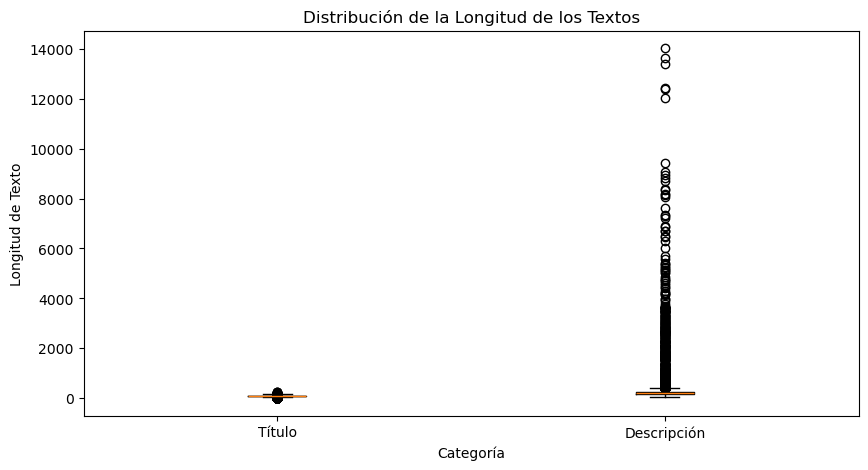

In [ ]:
longitudes_titulo = df["Titulo"].astype(str).apply(len)
longitudes_descripcion = df["Descripcion"].astype(str).apply(len)
plt.figure(figsize=(10, 5))
plt.boxplot([longitudes_titulo, longitudes_descripcion], labels=["Título", "Descripción"])
plt.title("Distribución de la Longitud de los Textos")
plt.ylabel("Longitud de Texto")
plt.xlabel("Categoría")
plt.show()

In [ ]:
df["longitud_titulo"] = df["Titulo"].astype(str).apply(len)
df["longitud_descripcion"] = df["Descripcion"].astype(str).apply(len)

def detectar_outliers(df, columna):
    Q1 = np.percentile(df[columna], 25)
    Q3 = np.percentile(df[columna], 75)
    IQR = Q3 - Q1
    umbral_inferior = Q1 - 1.5 * IQR
    umbral_superior = Q3 + 1.5 * IQR

    outliers = df[(df[columna] < umbral_inferior) | (df[columna] > umbral_superior)]

    print(f"Valores atípicos en {columna}: {len(outliers)}")
    return outliers

outliers_titulo = detectar_outliers(df, "longitud_titulo")
outliers_descripcion = detectar_outliers(df, "longitud_descripcion")


Valores atípicos en longitud_titulo: 430
Valores atípicos en longitud_descripcion: 2222


In [ ]:
df.columns

Index(['ID', 'Label', 'Titulo', 'Descripcion', 'Fecha', 'longitud_titulo',
       'longitud_descripcion'],
      dtype='object')

Ahora bien, el proceso realizado anteriormente, deja que la evaluación de la validez de los datos revela una alta presencia de valores atípicos en la longitud de los textos, especialmente en la columna `Descripcion`, donde se identificaron 2,222 valores extremos, y en `Titulo`, con 430 outliers. La gráfica confirma esta observación, mostrando una gran dispersión en la longitud de las descripciones, con textos que superan los 14,000 caracteres, mientras que los títulos tienen una variabilidad mucho menor. Estos outliers pueden indicar errores en la recolección de datos, presencia de textos inusualmente largos o diferencias en la estructura de los registros. Su impacto en el análisis y modelado es significativo, ya que pueden afectar la estabilidad de modelos predictivos, sesgar estadísticas descriptivas y alterar la interpretación de los datos.

# 3. Preparación de los datos

Para poder realizar el pre-procesamiento de los datos, realizamos las siguientes cuatro etapas:

- Limpieza de los datos.
- Tokenización.
- Normalización.
- Selección de campos.

## 3.1 Limpieza de los datos

Durante la fase de limpieza de datos, se llevaron a cabo diversas acciones para mejorar la calidad del texto antes de su análisis. En primer lugar, se eliminaron los caracteres no ASCII para garantizar un formato estándar compatible con los procesos de procesamiento. Luego, se convirtió todo el texto a minúsculas para evitar inconsistencias derivadas de la distinción entre mayúsculas y minúsculas. Además, se eliminaron los signos de puntuación y los números fueron convertidos a su forma textual, lo que contribuye a la uniformidad de los datos. Por último, se eliminaron las palabras vacías o *stopwords* en español, con el propósito de reducir el ruido y conservar únicamente los términos relevantes para el análisis. En conjunto, estos procedimientos optimizan la preparación de los datos para su posterior procesamiento y modelado.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
      n1word = word.lower()
      new_words.append(n1word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
       else:
           new_words.append(word)
   return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))
    new_words = [word for word in words if word not in stop_words]
    return new_words

def preprocessing(words):
    words = remove_punctuation(words)
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

Aparte de esto, se llevara a cabo los procesos de **completitud**, **unicidad**, **consistencia** y **validez** con el fin de tener los datos preparados para los procesos de **tokenizacion**







In [ ]:
df = df.dropna()

In [ ]:
datos_completos = df.notnull().sum()
print(datos_completos)

ID                      57047
Label                   57047
Titulo                  57047
Descripcion             57047
Fecha                   57047
longitud_titulo         57047
longitud_descripcion    57047
dtype: int64


In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

***Nota***: Ejecutar 3 veces para completar el filtro

In [ ]:
for i in range(3):
  Q1_titulo = np.percentile(df["longitud_titulo"], 25)
  Q3_titulo = np.percentile(df["longitud_titulo"], 75)
  IQR_titulo = Q3_titulo - Q1_titulo
  umbral_inf_titulo = Q1_titulo - 1.5 * IQR_titulo
  umbral_sup_titulo = Q3_titulo + 1.5 * IQR_titulo

  Q1_desc = np.percentile(df["longitud_descripcion"], 25)
  Q3_desc = np.percentile(df["longitud_descripcion"], 75)
  IQR_desc = Q3_desc - Q1_desc
  umbral_inf_desc = Q1_desc - 1.5 * IQR_desc
  umbral_sup_desc = Q3_desc + 1.5 * IQR_desc

  df = df[
      (df["longitud_titulo"] >= umbral_inf_titulo) & (df["longitud_titulo"] <= umbral_sup_titulo) &
      (df["longitud_descripcion"] >= umbral_inf_desc) & (df["longitud_descripcion"] <= umbral_sup_desc)
  ]

  outliers_titulo = detectar_outliers(df, "longitud_titulo")
  outliers_descripcion = detectar_outliers(df, "longitud_descripcion")

Valores atípicos en longitud_titulo: 0
Valores atípicos en longitud_descripcion: 661
Valores atípicos en longitud_titulo: 0
Valores atípicos en longitud_descripcion: 31
Valores atípicos en longitud_titulo: 0
Valores atípicos en longitud_descripcion: 0


/tmp/ipykernel_14342/2295891094.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([longitudes_titulo, longitudes_descripcion], labels=["Título", "Descripción"])


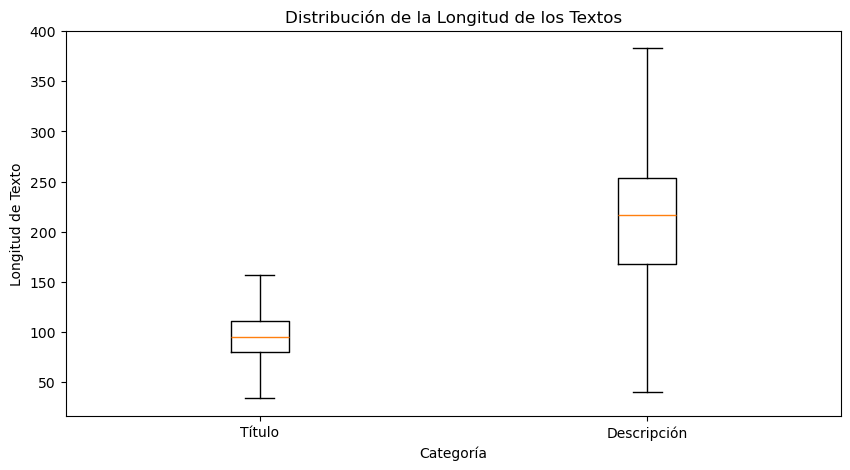

In [ ]:
longitudes_titulo = df["Titulo"].astype(str).apply(len)
longitudes_descripcion = df["Descripcion"].astype(str).apply(len)
plt.figure(figsize=(10, 5))
plt.boxplot([longitudes_titulo, longitudes_descripcion], labels=["Título", "Descripción"])
plt.title("Distribución de la Longitud de los Textos")
plt.ylabel("Longitud de Texto")
plt.xlabel("Categoría")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53337 entries, 0 to 57062
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    53337 non-null  object
 1   Label                 53337 non-null  int64 
 2   Titulo                53337 non-null  object
 3   Descripcion           53337 non-null  object
 4   Fecha                 53337 non-null  object
 5   longitud_titulo       53337 non-null  int64 
 6   longitud_descripcion  53337 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 3.3+ MB


El último paso para completar la limpieza consiste en equilibrar la cantidad de datos entre ambas etiquetas. Esto es crucial para evitar que el modelo aprenda un sesgo hacia la clase mayoritaria, lo que podría afectar su capacidad de generalización. Al mantener una distribución equitativa, se garantiza que el modelo tenga suficiente representación de ambas clases, permitiéndole aprender patrones más representativos y mejorar su rendimiento en datos no vistos.

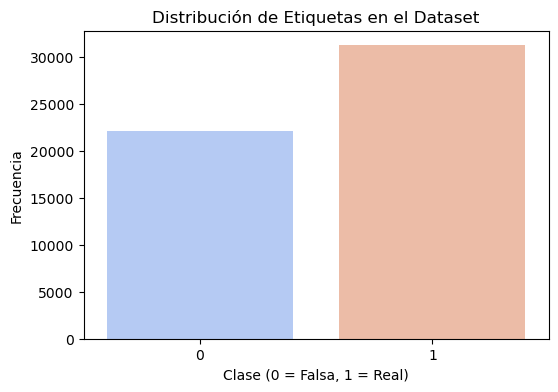

In [ ]:
label_counts = df["Label"].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="coolwarm", legend=False)
plt.xlabel("Clase (0 = Falsa, 1 = Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Etiquetas en el Dataset")
plt.show()


In [ ]:
minoria = df["Label"].value_counts().min()
df = df.groupby("Label").apply(lambda x: x.sample(minoria, random_state=42)).reset_index(drop=True)
print(df["Label"].value_counts())

Label
0    22136
1    22136
Name: count, dtype: int64


/tmp/ipykernel_14342/3597969631.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Label").apply(lambda x: x.sample(minoria, random_state=42)).reset_index(drop=True)


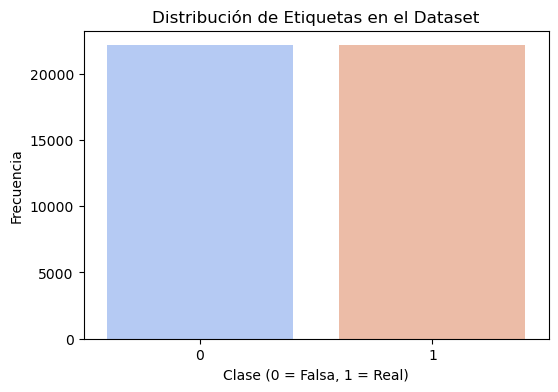

In [ ]:
label_counts = df["Label"].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="coolwarm", legend=False)
plt.xlabel("Clase (0 = Falsa, 1 = Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Etiquetas en el Dataset")
plt.show()


## 3.2 Tokenización

La tokenización facilita la segmentación de frases u oraciones en palabras, lo que permite desglosarlas adecuadamente para su análisis posterior. Sin embargo, antes de este proceso, se lleva a cabo una corrección de las contracciones que puedan aparecer en los textos para garantizar una segmentación más precisa.

In [ ]:
df['Titulo'] = df['Titulo'].apply(lambda x: contractions.fix(str(x)) if pd.notnull(x) else "")
df['Descripcion'] = df['Descripcion'].apply(lambda x: contractions.fix(str(x)) if pd.notnull(x) else "")

In [ ]:
df['Titulo'] = df['Titulo'].apply(contractions.fix)
df['Descripcion'] = df['Descripcion'].apply(contractions.fix)


In [ ]:
df['titulo-words'] = df['Titulo'].apply(word_tokenize)
df['descripcion-words'] = df['Descripcion'].apply(word_tokenize)

In [ ]:
df.head()

,ID,Label,Titulo,Descripcion,Fecha,longitud_titulo,longitud_descripcion,titulo-words,descripcion-words
0,ID,0,Sondeos: Feijóo acumula todo el voto de la der...,El hundimiento de la coalición En Común/En Mar...,11/06/2020,106,362,"[Sondeos, :, Feijóo, acumula, todo, el, voto, ...","[El, hundimiento, de, la, coalición, En, Común..."
1,ID,0,Boluarte pide a Coalición Canaria no concurrir...,La formación ultra responde al líder del Inici...,13/03/2019,107,148,"[Boluarte, pide, a, Coalición, Canaria, no, co...","[La, formación, ultra, responde, al, líder, de..."
2,ID,0,El Gobierno presentará sólo los PGE de 2021 si...,La ministra de Hacienda sigue condicionando su...,04/03/2020,92,351,"[El, Gobierno, presentará, sólo, los, PGE, de,...","[La, ministra, de, Hacienda, sigue, condiciona..."
3,ID,0,Vallejo garantiza 'elecciones en paz' en Venez...,"El expresidente asegura que de lo contrario, n...",10/04/2018,50,215,"[Vallejo, garantiza, 'elecciones, en, paz, ', ...","[El, expresidente, asegura, que, de, lo, contr..."
4,ID,0,Cristina Narbona admite que Catalunya vote 'po...,El presidente del Gobierno tiene por delante u...,03/09/2018,94,334,"[Cristina, Narbona, admite, que, Catalunya, vo...","[El, presidente, del, Gobierno, tiene, por, de..."


In [ ]:
df['titulo-words'] = df['titulo-words'].apply(preprocessing)
df['descripcion-words'] = df['descripcion-words'].apply(preprocessing)
df.head()

,ID,Label,Titulo,Descripcion,Fecha,longitud_titulo,longitud_descripcion,titulo-words,descripcion-words
0,ID,0,Sondeos: Feijóo acumula todo el voto de la der...,El hundimiento de la coalición En Común/En Mar...,11/06/2020,106,362,"[sondeos, feijoo, acumula, voto, derecha, repe...","[hundimiento, coalicion, comunen, marea, perde..."
1,ID,0,Boluarte pide a Coalición Canaria no concurrir...,La formación ultra responde al líder del Inici...,13/03/2019,107,148,"[boluarte, pide, coalicion, canaria, concurrir...","[formacion, ultra, responde, lider, iniciativa..."
2,ID,0,El Gobierno presentará sólo los PGE de 2021 si...,La ministra de Hacienda sigue condicionando su...,04/03/2020,92,351,"[gobierno, presentara, solo, pge, two thousand...","[ministra, hacienda, sigue, condicionando, pre..."
3,ID,0,Vallejo garantiza 'elecciones en paz' en Venez...,"El expresidente asegura que de lo contrario, n...",10/04/2018,50,215,"[vallejo, garantiza, elecciones, paz, venezuela]","[expresidente, asegura, contrario, participari..."
4,ID,0,Cristina Narbona admite que Catalunya vote 'po...,El presidente del Gobierno tiene por delante u...,03/09/2018,94,334,"[cristina, narbona, admite, catalunya, vote, a...","[presidente, gobierno, delante, agenda, politi..."


## 3.3 Normalización

En el proceso de normalización de datos, se eliminan prefijos y sufijos, además de aplicar lematización.

In [ ]:
stemmer = SnowballStemmer("spanish")

def stem_words(words):
    """Stem words in list of tokenized words"""
    stems = [stemmer.stem(word) for word in words]
    return stems

def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    """Apply stemming and lemmatization to words"""
    #stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return lemmas


In [ ]:
df['titulo-words'] = df['titulo-words'].apply(stem_and_lemmatize)
df['descripcion-words'] = df['descripcion-words'].apply(stem_and_lemmatize)
df.head()

,ID,Label,Titulo,Descripcion,Fecha,longitud_titulo,longitud_descripcion,titulo-words,descripcion-words
0,ID,0,Sondeos: Feijóo acumula todo el voto de la der...,El hundimiento de la coalición En Común/En Mar...,11/06/2020,106,362,"[sondeos, feijoo, acumula, voto, derecha, repe...","[hundimiento, coalicion, comunen, marea, perde..."
1,ID,0,Boluarte pide a Coalición Canaria no concurrir...,La formación ultra responde al líder del Inici...,13/03/2019,107,148,"[boluarte, pide, coalicion, canaria, concurrir...","[formacion, ultra, responde, lider, iniciativa..."
2,ID,0,El Gobierno presentará sólo los PGE de 2021 si...,La ministra de Hacienda sigue condicionando su...,04/03/2020,92,351,"[gobierno, presentara, solo, pge, two thousand...","[ministra, hacienda, sigue, condicionando, pre..."
3,ID,0,Vallejo garantiza 'elecciones en paz' en Venez...,"El expresidente asegura que de lo contrario, n...",10/04/2018,50,215,"[vallejo, garantiza, elecciones, paz, venezuela]","[expresidente, asegura, contrario, participari..."
4,ID,0,Cristina Narbona admite que Catalunya vote 'po...,El presidente del Gobierno tiene por delante u...,03/09/2018,94,334,"[cristina, narbona, admite, catalunya, vote, a...","[presidente, gobierno, delante, agenda, politi..."


## 3.4 Selección de campos

En el proceso de selección de características para el modelo de clasificación, se han considerado las siguientes variables clave:

- **Título**  (titulo-words)
- **Descripción**  (descripcion-words)

La decisión de utilizar únicamente estos campos y excluir el resto se basa en los siguientes criterios:

1. **Relevancia Semántica:**  
   Tanto el `Titulo` como la `Descripcion` contienen información textual directamente relacionada con el contenido de la noticia. Estas variables son las que pueden aportar patrones lingüísticos, semánticos y estructurales relevantes para diferenciar noticias falsas de reales.

2. **Evitar Sesgos Indeseados:**  
   Variables como `ID` y `Fecha` no aportan información útil para la clasificación, ya que `ID` es solo un identificador único sin valor predictivo, y `Fecha` podría inducir sesgos temporales que afecten la generalización del modelo a datos futuros.

In [ ]:
df.columns

Index(['ID', 'Label', 'Titulo', 'Descripcion', 'Fecha', 'longitud_titulo',
       'longitud_descripcion', 'titulo-words', 'descripcion-words'],
      dtype='object')

In [ ]:
df['titulo-words'] = df['titulo-words'].apply(lambda x: ' '.join(map(str, x)))
df['descripcion-words'] = df['descripcion-words'].apply(lambda x: ' '.join(map(str, x)))
df

,ID,Label,Titulo,Descripcion,Fecha,longitud_titulo,longitud_descripcion,titulo-words,descripcion-words
0,ID,0,Sondeos: Feijóo acumula todo el voto de la der...,El hundimiento de la coalición En Común/En Mar...,11/06/2020,106,362,sondeos feijoo acumula voto derecha repetiria ...,hundimiento coalicion comunen marea perderia m...
1,ID,0,Boluarte pide a Coalición Canaria no concurrir...,La formación ultra responde al líder del Inici...,13/03/2019,107,148,boluarte pide coalicion canaria concurrir prov...,formacion ultra responde lider iniciativa vers...
2,ID,0,El Gobierno presentará sólo los PGE de 2021 si...,La ministra de Hacienda sigue condicionando su...,04/03/2020,92,351,gobierno presentara solo pge two thousand and ...,ministra hacienda sigue condicionando presenta...
3,ID,0,Vallejo garantiza 'elecciones en paz' en Venez...,"El expresidente asegura que de lo contrario, n...",10/04/2018,50,215,vallejo garantiza elecciones paz venezuela,expresidente asegura contrario participaria ac...
4,ID,0,Cristina Narbona admite que Catalunya vote 'po...,El presidente del Gobierno tiene por delante u...,03/09/2018,94,334,cristina narbona admite catalunya vote autogob...,presidente gobierno delante agenda politica co...
...,...,...,...,...,...,...,...,...,...
44267,ID,1,Cuca Gamarra: 'El PP ha frenado a Vox en Andal...,Génova lee los resultados en clave nacional y ...,19/06/2022,78,197,cuca gamarra pp frenado vox andalucia hecho si...,genova lee resultados clave nacional ve nunez ...
44268,ID,1,Llamazares dimite de sus cargos en IU: 'Llamo ...,El líder de Izquierda Abierta denuncia una cam...,24/12/2018,94,189,llamazares dimite cargos iu llamo rebelarse de...,lider izquierda abierta denuncia campana linch...
44269,ID,1,Detenido un profesor por abusos sexuales a dos...,El arrestado está siendo investigado por abuso...,15/06/2018,67,167,detenido profesor abusos sexuales do menores h...,arrestado siendo investigado abusos sexuales r...
44270,ID,1,El largo y complicado camino que le espera al ...,Eliminar de golpe el área restringida al tráfi...,28/05/2019,80,212,largo complicado camino espera pp si quiere tu...,eliminar golpe area restringida trafico necesi...


In [ ]:
df.to_csv('./data/datos_filtrados.csv', index=False)

## 4. Modelos y Evaluacion

Los modelos realizados por cada uno de los estudiantes se encontrara en la carpeta principal.
- Decision Tree (Tomas Rodriguez)
- Random Forest (Adriana Sofia Rozo)
- Logistic Regression (Andres Caballero)

## 5. Resultados

| Modelo  | Exactitud | Recall   | Precision  | F1-score  |
| ------------ | ------------ | ------------ | ------------ | ------------ |
|  Decision Tree | 0.92 | 0.92  | 0.92  | 0.92  |
|  Random Forest | 0.92|   0.92| 0.92  |   0.92|
| Logistic Regression  | 0.90  | 0.90  | 0.90  |  0.90 |

Como nuestro objetivo es **minimizar la cantidad de noticias falsas clasificadas erróneamente como verdaderas**, el mejor modelo es **Árboles de Decisión**. Este modelo tiene una **precisión del 92% en la detección de noticias falsas**, lo que significa que comete menos **falsos positivos (617)** en comparación con **Random Forest (742)** y **Regresión Logística (825)**. Aunque Random Forest tiene un mejor recall en la clase "verdadera" (0.95), su recall en la clase "falsa" es menor (0.89 frente a 0.91 en Árboles de Decisión), lo que indica que deja pasar más noticias falsas como verdaderas. Por otro lado, la regresión logística es la peor opción en este caso, ya que tiene la mayor cantidad de falsos positivos y menor precisión en detectar noticias falsas.

En conclusión, podemos decir que **Árboles de Decisión es la mejor opción**, ya que maximiza la precisión en la detección de noticias falsas, reduciendo el riesgo de clasificar incorrectamente una noticia falsa como verdadera.

# **Trabajo en Equipo - División de roles y tareas**  

Lo puedes encontrar en el siguiente apartado en la wiki : [Trabajo en equipo](https://github.com/Inteligencia-de-Negocios-202501/proyecto-analitica-de-datos/wiki/Trabajo-de-Equipo) 